# Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [1]:
#!pip install medmnist
#!pip install torchinfo

In [2]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [3]:
import medmnist
from medmnist import INFO, Evaluator

data_flag = 'pathmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  9
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [4]:

train_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image. However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, the gap between the original ImageNet domain and the medical images is wide. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.


In [5]:
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')


The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [6]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

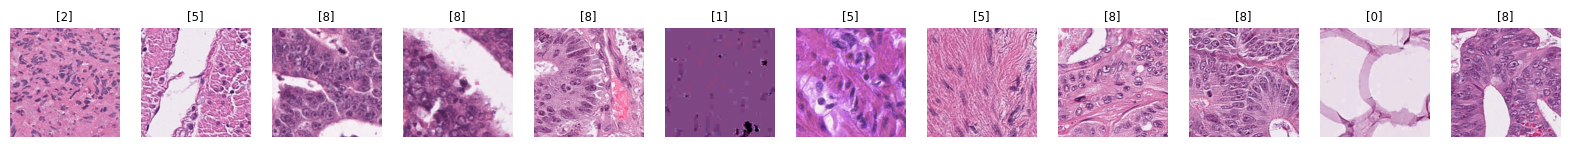

In [7]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
import torchvision
from torchinfo import summary


In [10]:
pretrained = torchvision.models.resnet18(weights="IMAGENET1K_V1")
class pathMedMNIST_Classifier(nn.Module):
    def __init__(self, my_pretrained_model, num_classes=9):
        super(pathMedMNIST_Classifier, self).__init__()
        self.weights = my_pretrained_model

        for param in self.weights.parameters():
            param.requires_grad=False

        in_features = self.weights.fc.in_features
        self.weights.fc = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, num_classes)
        )
    
    def forward(self, x):
        x = self.weights(x)
        return x

my_extended_model = pathMedMNIST_Classifier(my_pretrained_model=pretrained, num_classes = 9)
print(summary(my_extended_model, input_size=(BATCH_SIZE, 3, 28, 28)))

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    param_report = (
        f"Total parameters: {total_params:,}\n"
        f"Trainable parameters: {trainable_params:,}\n"
        f"Frozen parameters: {frozen_params:,}\n"
    )
    
    return param_report

print(count_parameters(my_extended_model))


Layer (type:depth-idx)                        Output Shape              Param #
pathMedMNIST_Classifier                       [64, 9]                   --
├─ResNet: 1-1                                 [64, 9]                   --
│    └─Conv2d: 2-1                            [64, 64, 14, 14]          (9,408)
│    └─BatchNorm2d: 2-2                       [64, 64, 14, 14]          (128)
│    └─ReLU: 2-3                              [64, 64, 14, 14]          --
│    └─MaxPool2d: 2-4                         [64, 64, 7, 7]            --
│    └─Sequential: 2-5                        [64, 64, 7, 7]            --
│    │    └─BasicBlock: 3-1                   [64, 64, 7, 7]            (73,984)
│    │    └─BasicBlock: 3-2                   [64, 64, 7, 7]            (73,984)
│    └─Sequential: 2-6                        [64, 128, 4, 4]           --
│    │    └─BasicBlock: 3-3                   [64, 128, 4, 4]           (230,144)
│    │    └─BasicBlock: 3-4                   [64, 128, 4, 4]       

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

In [11]:
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import shutil
shutil.rmtree('runs', ignore_errors=True) # Remove existing 'runs' directory if it exists
writer = SummaryWriter('runs')

In [12]:
import torch.optim as optim

# Define loss and optimizer and optional learning rate scheduler to improve training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_extended_model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_extended_model = my_extended_model.to(device)

# Basic loop
num_epochs = 20 

for epoch in tqdm(range(num_epochs)):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)
    
    # ---- TRAINING PHASE ----
    my_extended_model.train()  # set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.squeeze(labels)  # make sure labels are 1D
        
        optimizer.zero_grad()           # clear old gradients
        outputs = my_extended_model(inputs)  # forward pass
        loss = criterion(outputs, labels)    # compute loss
        loss.backward()                     # backpropagation
        optimizer.step()                    # update weights
        
        running_loss += loss.item()
        
        # --- Track training accuracy ---
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels)
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train.double() / total_train
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    
    # ---- VALIDATION PHASE ----
    my_extended_model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # no gradient calculation in validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.squeeze(labels)
            
            outputs = my_extended_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
    
    val_loss = val_loss / len(val_dataloader)
    val_acc = correct.double() / total
    
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
        # ---- TENSORBOARD LOGGING ----

    scheduler.step(val_loss)

    writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
    
    writer.add_scalars(
        'Loss',
        {'Training Loss': train_loss, 'Validation Loss': val_loss},
        epoch
    )
    writer.add_scalars(
        'Accuracy',
        {'Training Acc': train_acc, 'Validation Acc': val_acc},
        epoch
)


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
--------------------
Training Loss: 0.5659 | Training Accuracy: 0.8483
Validation Loss: 0.2119 | Validation Accuracy: 0.9391

Epoch 2/20
--------------------


c:\Users\cianm\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Loss: 0.2388 | Training Accuracy: 0.9243
Validation Loss: 0.1610 | Validation Accuracy: 0.9495

Epoch 3/20
--------------------
Training Loss: 0.1993 | Training Accuracy: 0.9370
Validation Loss: 0.1445 | Validation Accuracy: 0.9518

Epoch 4/20
--------------------
Training Loss: 0.1820 | Training Accuracy: 0.9415
Validation Loss: 0.1309 | Validation Accuracy: 0.9573

Epoch 5/20
--------------------
Training Loss: 0.1677 | Training Accuracy: 0.9454
Validation Loss: 0.1222 | Validation Accuracy: 0.9604

Epoch 6/20
--------------------
Training Loss: 0.1591 | Training Accuracy: 0.9487
Validation Loss: 0.1199 | Validation Accuracy: 0.9606

Epoch 7/20
--------------------
Training Loss: 0.1519 | Training Accuracy: 0.9507
Validation Loss: 0.1114 | Validation Accuracy: 0.9633

Epoch 8/20
--------------------
Training Loss: 0.1453 | Training Accuracy: 0.9526
Validation Loss: 0.1091 | Validation Accuracy: 0.9640

Epoch 9/20
--------------------
Training Loss: 0.1405 | Training Accuracy

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


In [ ]:
# Unfreeze all parameters in the base model for fine-tuning
def unfreeze_all_parameters(model):
    # The 'weights' attribute holds the pretrained ResNet model
    for param in model.weights.parameters():
        param.requires_grad = True
    
    print("All base model parameters are now unfrozen and trainable.")

# Apply the unfreeze function to the model
unfreeze_all_parameters(my_extended_model)

# Sanity check: verify the new parameter count report
print("\n--- Parameter Report (Fine-Tuning) ---")
print(count_parameters(my_extended_model))
print("--------------------------------------\n")

# Re-define optimizer with a much lower learning rate for fine-tuning
# to avoid destroying the good features learned by the pretrained model.
new_optimizer = optim.Adam(my_extended_model.parameters(), lr=0.00001) # Reduced LR
new_scheduler = optim.lr_scheduler.StepLR(new_optimizer, step_size=3, gamma=0.1)

# Set the number of epochs for the fine-tuning stage
fine_tune_epochs = 10

All base model parameters are now unfrozen and trainable.

--- Parameter Report (Fine-Tuning) ---
Total parameters: 11,228,721
Trainable parameters: 11,228,721
Frozen parameters: 0

--------------------------------------



In [14]:
# Fine-Tuning Loop
for epoch in tqdm(range(fine_tune_epochs)):
    # Calculate the total epoch count for TensorBoard logging to be continuous
    current_epoch = num_epochs + epoch 
    
    print(f"\nFine-Tune Epoch {epoch+1}/{fine_tune_epochs} (Total Epoch {current_epoch+1})")
    print("-" * 30)
    
    # ---- TRAINING PHASE ----
    my_extended_model.train()  # set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use the same dataloader as before
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.squeeze(labels)
        
        new_optimizer.zero_grad()  # Use the *new* optimizer
        outputs = my_extended_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        new_optimizer.step()
        
        running_loss += loss.item()
        
        # --- Track training accuracy ---
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels)
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train.double() / total_train
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")
    
    # ---- VALIDATION PHASE ----
    my_extended_model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.squeeze(labels)
            
            outputs = my_extended_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)
    
    val_loss = val_loss / len(val_dataloader)
    val_acc = correct.double() / total
    
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    
    # ---- SCHEDULER STEP AND TENSORBOARD LOGGING ----
    
    # Step the new scheduler
    new_scheduler.step(val_loss)

    # Log with the total epoch count for continuous plotting
    writer.add_scalar('Learning Rate', new_optimizer.param_groups[0]['lr'], current_epoch)
    
    writer.add_scalars(
        'Loss',
        {'Training Loss': train_loss, 'Validation Loss': val_loss},
        current_epoch
    )
    writer.add_scalars(
        'Accuracy',
        {'Training Acc': train_acc, 'Validation Acc': val_acc},
        current_epoch
    )

# Close the writer after the fine-tuning stage is complete
writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]


Fine-Tune Epoch 1/10 (Total Epoch 21)
------------------------------
Training Loss: 0.0713 | Training Accuracy: 0.9768
Validation Loss: 0.0360 | Validation Accuracy: 0.9891

Fine-Tune Epoch 2/10 (Total Epoch 22)
------------------------------
Training Loss: 0.0358 | Training Accuracy: 0.9884
Validation Loss: 0.0231 | Validation Accuracy: 0.9926

Fine-Tune Epoch 3/10 (Total Epoch 23)
------------------------------
Training Loss: 0.0216 | Training Accuracy: 0.9935
Validation Loss: 0.0224 | Validation Accuracy: 0.9928

Fine-Tune Epoch 4/10 (Total Epoch 24)
------------------------------
Training Loss: 0.0155 | Training Accuracy: 0.9948
Validation Loss: 0.0210 | Validation Accuracy: 0.9932

Fine-Tune Epoch 5/10 (Total Epoch 25)
------------------------------
Training Loss: 0.0102 | Training Accuracy: 0.9968
Validation Loss: 0.0191 | Validation Accuracy: 0.9940

Fine-Tune Epoch 6/10 (Total Epoch 26)
------------------------------
Training Loss: 0.0078 | Training Accuracy: 0.9976
Validation

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



In [15]:
import numpy as np

my_extended_model.eval()
store_predictions = []
store_labels = []

classes = [
    "1 - adipose",
    "2 - background",
    "3 - debris",
    "4 - lymphocytes",
    "5 - mucus",
    "6 - smooth muscle",
    "7 - normal colon mucosa",
    "8 - cancer-associated stroma",
    "9 - colorectal adenocarcinoma epithelium"
]

with torch.no_grad():
    for input_batch, label_batch in test_dataloader:
        input_batch = input_batch.to(device)
        label_batch = label_batch.to(device)
        
        pred_logit = my_extended_model(input_batch)
        predictions = torch.argmax(pred_logit, dim=1)
        
        store_predictions.append(predictions.cpu().numpy())
        store_labels.append(label_batch.cpu().numpy())

# concatenate all batches into 1D arrays
y_pred = np.concatenate(store_predictions)
y_true = np.concatenate(store_labels)

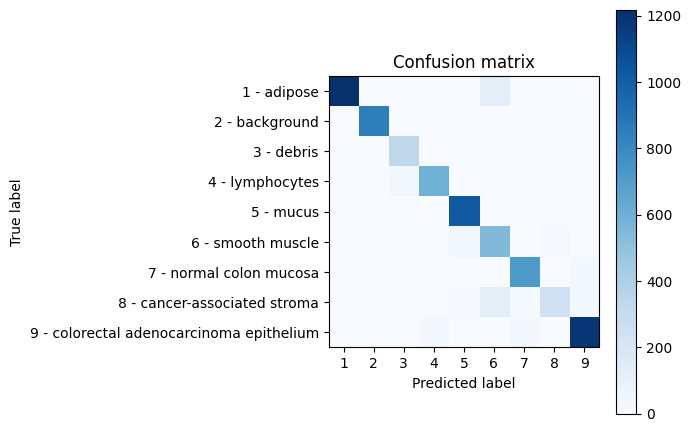

In [16]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, range(1,10))
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

                                          precision    recall  f1-score   support

                             1 - adipose       1.00      0.91      0.95      1338
                          2 - background       1.00      1.00      1.00       847
                              3 - debris       0.88      0.98      0.93       339
                         4 - lymphocytes       0.96      0.94      0.95       634
                               5 - mucus       0.95      0.99      0.97      1035
                       6 - smooth muscle       0.70      0.92      0.79       592
                 7 - normal colon mucosa       0.94      0.96      0.95       741
            8 - cancer-associated stroma       0.96      0.58      0.72       421
9 - colorectal adenocarcinoma epithelium       0.95      0.96      0.96      1233

                                accuracy                           0.93      7180
                               macro avg       0.93      0.92      0.91      7180
              

 # Comments about your Approach

 Hi All,

This is my reflection post for this week, I would like to thank my peers for their feedback and discussions this week as your input resulted in a considerably better performing model for this assignment.

As outlined above I was working with the PathMNIST dataset consisting of 9 classes associated of colorectal medical tissue sample images. As discussed in the forums with by using ResNet-15 and just adjusting the classifier head I achieved accuracy of approximately 0.91, I struggled to improve upon this with data augmentations or learning rate schedulers, The consistent class that presented issues for me was "cancer-associated stroma" which had F1-Score of 0.7 on my initial attempt.

The confusion matrix and classification report for this initial attempt is below:
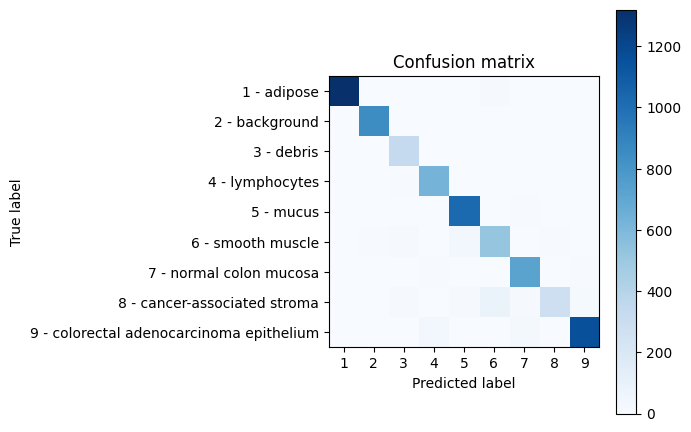
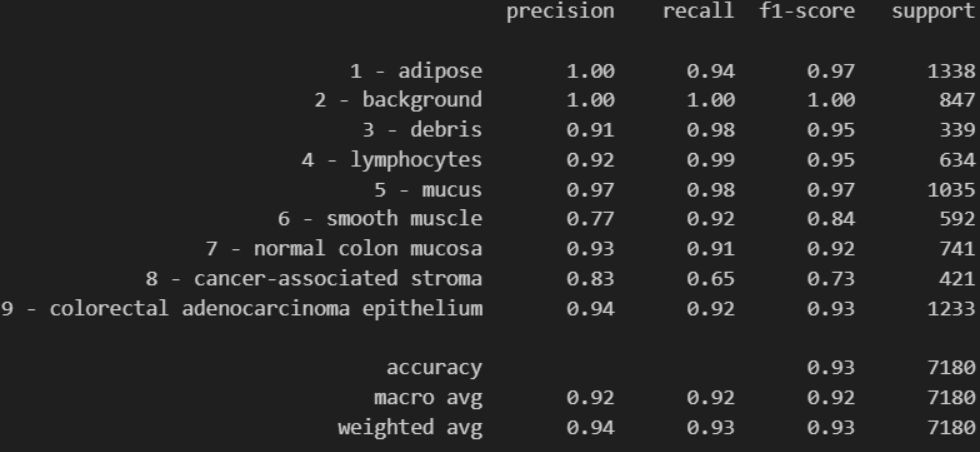

The following observations and feedback were discussed in the forums:

 - Nicola Fiano queried how I had achieved such good results for the mucus class while his solution and others had limited results with this class due to the complex and non-defining features. This prompted me to review my solution and assess this, what was discovered is the training approach I had taken did not struggle with Mucus but did with cancer-associated stroma. I did note to Nicola that a conversion of his testing data to floating point was not being performed in the training data and this may be contributing to the lower results.
 - I responded to Rafael Conrado's post where his results of 0.99 were resulting in questioning if an error had occurred, we discussed that the PathMNIST dataset is large and that it may be possible that these above benchmark results are due to the abundance of data and the right tailored set of data augmentations. I did highlight in a subsequent response that there was potential data leakage occurring as the same dataset was being used within the training loop as was being used for the evaluation of the final model which could amplify the performance beyond what it could do on a new dataset.
 - Abderahman Haouit presented his approach for a 2 phases of training, and initial training to add the classifier head and a second phase to fine tune the rest of the model. I used this approach in my final solution having reviewed Abder's approach. We also discussed the care required when performing data augmentations and the benefit of domain knowledge for certain augmentations as they may create a training test set that is not representative of the real-world scenarios and identify color based features that are not present in raw images.

Using the feedback and discussions from above my final model achieved superior results than the initial model and the benchmark performance for PathMNIST based on accuracy.
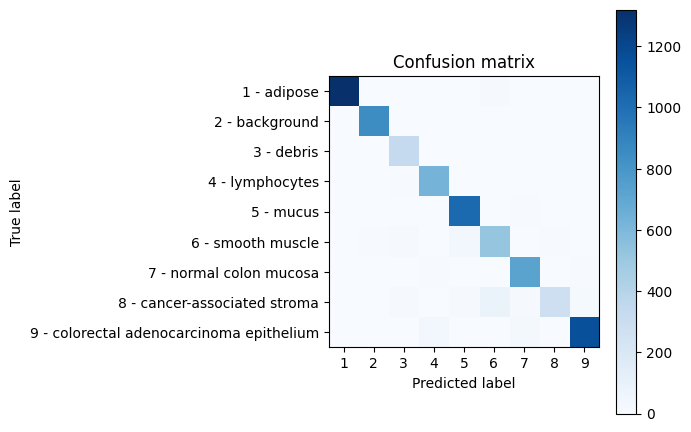
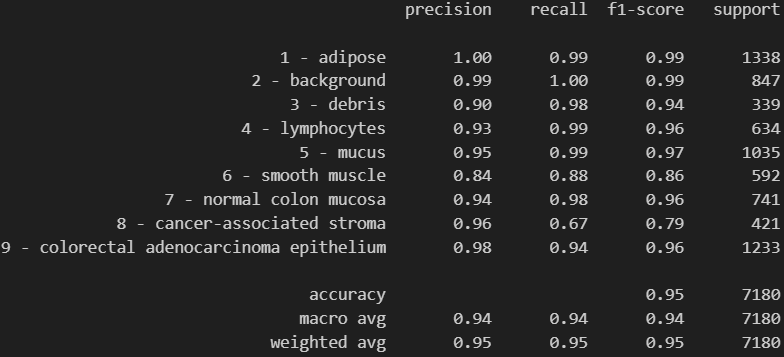


As can be seen in the outputs above result in a better performing model, the lowest performing model still looks to be the cancer associated stroma, however it was a 6 point improvement for the stroma class from the original attempt.

The classification head training was conducted over 20 Epochs, and the fine tuning of the remaining parameters after unfreezing them was 10 Epochs.

The initial head training had 52,209 parameters, while the second phase had 11,228,721 parameters to fine tune, a lower learning rate was used for the fine tuning to avoid undoing the progress of the original classification head parameters. The final results as visualised above was accuracy of 0.95.

This assignment showed the benefits of transfer learning in the image domain, and with the support of peers I implemented a solution for the PathMNIST that added a new classification section to the model and retrained the entire model for finetuning resulting in a model that exceeded the benchmark score for accuracy of 0.91.

Kind Regards,

Cian